In [1]:
# for switching between GPU and CPU
NO_GPU = False

import os
from os.path import exists
if NO_GPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl
from keras.preprocessing.image import ImageDataGenerator
import scipy
import skimage, skimage.draw, skimage.transform
import random

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
def show_imgs(images, columns=9, figsize=(15,7), title=''):
    """Displays images in a grid"""
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    rows = np.ceil(len(images)/columns).astype('int')
    
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        f = plt.imshow(images[i-1], cmap=plt.cm.binary)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [5]:
def all_same_length(*args):
    """Returns True if all arguments have equal len(.)"""
    return all(len(a) == len(args[0]) for a in args)

def shuffle_together(*numpy_arrays):
    """Shuffles numpy arrays in unison, returns a tuple.
    
    (applies the same random permutation to all of them,
    so they have to be the same length on axis=0)"""
    
    assert all_same_length(*numpy_arrays)
    permut = np.random.permutation(len(numpy_arrays[0]))
    return tuple(a[permut] for a in numpy_arrays)

In [6]:
def feature_smoothen(img):
    i = scipy.ndimage.filters.gaussian_filter(img, 0.16)
    #i = scipy.ndimage.filters.uniform_filter(img)
    #i = restoration.denoise_tv_chambolle(img)
    return i * (i > 0.2)

def feature_sobel(img):
    return scipy.ndimage.filters.sobel(img)
    
def feature_remove_dust(img):
    out_img = img.copy()
    labeled_img, nobjs = scipy.ndimage.label(img)
    if nobjs > 1: 
        label_count_pairs = zip(*np.unique(labeled_img, return_counts=1))
        label_count_pairs = sorted(label_count_pairs, key=lambda x: x[1], reverse=1)
        
        mask = np.zeros(img.shape)
        for i in range(nobjs):
            label, count = label_count_pairs[i]
            if i < 2 or count > 15:
                mask += (labeled_img == label)
        out_img *= mask
    return out_img

In [7]:
def feature_autoscale(img):
    img = img.copy()

    while not any(img[   0]): img = img[1:]
    while not any(img[  -1]): img = img[ :-1]
    while not any(img[:, 0]): img = img[:,1:]
    while not any(img[:,-1]): img = img[:, :-1]

    return skimage.transform.resize(img, (28,28))

In [8]:
def normalize_arr(arr):
    return arr / np.max(arr)

def feature_histogram_vert(img):
    return normalize_arr(np.apply_along_axis(sum, 0, img))

def feature_histogram_horiz(img):
    return normalize_arr(np.apply_along_axis(sum, 1, img))

EDGES = []
EDGES.extend([(i,  0) for i in range(13, -1, -1)])
EDGES.extend([(0 , i) for i in range(28)])
EDGES.extend([(i, 27) for i in range(28)])
EDGES.extend([(27, i) for i in range(27, -1, -1)])
EDGES.extend([(i,  0) for i in range(27, 13, -1)])
MIDDLES = tuple((13 + c0 // 14, 13 + c1 // 14) for c0, c1 in EDGES)
LINES = tuple(map(lambda m, e: skimage.draw.line_aa(*m,*e), MIDDLES, EDGES))

def feature_histogram_circ(img):
    sum_point = lambda r,c,v: v*img[r,c]
    sum_line = lambda line: sum(map(sum_point, *line))
    return normalize_arr(np.array(tuple(map(sum_line, LINES))))

In [9]:
INPUT_SHAPE = (-1, 28, 28, 1)
VERBOSE=True

BS = 500
EPOCHS=50
GEN_KWARGS = {} #dict(samplewise_center=True, samplewise_std_normalization=True)


In [36]:
#### Import the dataset & apply transformations
from urllib.request import urlretrieve
filename, headers = urlretrieve(
    'https://github.com/Avatust/my-mnist-digits/raw/master/data/digits.npz')

with np.load(filename) as data:
    x_test = data['input_data']
    y_test = data['target_data']
    
y_test =  keras.utils.to_categorical(y_test)
x_test =  x_test.astype('float32') / 255.0
x_test_no_dust = np.array(
    [
        scipy.ndimage.grey_dilation(
            feature_remove_dust(feature_smoothen(x)),
            size=[2,2])
        for x in x_test
    ])
x_test_no_dust_autoscaled = np.array([feature_autoscale(x) for x in x_test_no_dust])
    
IMG_DIR_BASE = 'images_from_flow/autoscaled_augmented'
if exists(IMG_DIR_BASE):
    makeflow = lambda subdir: ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
        os.path.join(IMG_DIR_BASE, subdir),
        target_size=(28,28),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=BS,
    )
    flow_train_data = makeflow('train')
    flow_valid_data = makeflow('valid')
    
else:
    (x_train, y_train), (x_valid, y_valid) = keras.datasets\
                                            .mnist.load_data()

    y_train = keras.utils.to_categorical(y_train)
    y_valid = keras.utils.to_categorical(y_valid)

    x_train = x_train.astype('float32') / 255.0
    x_valid = x_valid.astype('float32') / 255.0

    preprocess = lambda x: feature_remove_dust(feature_smoothen(x))
    x_train_no_dust = np.array([preprocess(x) for x in x_train]) 
    x_valid_no_dust = np.array([preprocess(x) for x in x_valid]) 

    scale = lambda x: feature_autoscale(x.reshape(28, 28)).reshape(28, 28, 1)
    data_gen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.13, height_shift_range=0.13,
                                   shear_range=0.2, zoom_range=0.1,
                                   fill_mode='constant', cval=0.0,
                                   data_format='channels_last', preprocessing_function=scale)
    flow_train_data = data_gen.flow(x_train_no_dust.reshape(INPUT_SHAPE), y_train, batch_size=BS)
    flow_valid_data = data_gen.flow(x_valid_no_dust.reshape(INPUT_SHAPE), y_valid, batch_size=BS)
    
#x_train_no_dust_sobel = np.array(tuple(map(feature_sobel, x_train_no_dust)))
#x_valid_no_dust_sobel = np.array(tuple(map(feature_sobel, x_valid_no_dust)))
#x_test_no_dust_sobel = np.array(tuple(map(feature_sobel, x_test_no_dust)))
#
#x_train_no_dust_autoscaled = np.array(tuple(map(feature_autoscale, x_train_no_dust)))
#x_valid_no_dust_autoscaled = np.array(tuple(map(feature_autoscale, x_valid_no_dust)))
#x_test_no_dust_autoscaled = np.array(tuple(map(feature_autoscale, x_test_no_dust)))

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Found 1000000 images belonging to 10 classes.
Found 100000 images belonging to 10 classes.


In [37]:
def get_histogram(img):
    return np.concatenate((feature_histogram_horiz(img), 
                           feature_histogram_vert(img),
                           feature_histogram_circ(img)))

def transform_to_histograms(img_array):
    return np.array([get_histogram(img) for img in img_array])

#x_train_histograms = transform_to_histograms(x_train_no_dust_autoscaled)
#x_valid_histograms = transform_to_histograms(x_valid_no_dust_autoscaled)
x_test_histograms =  transform_to_histograms(x_test_no_dust_autoscaled)

In [38]:
def make_histogram_flow(data_flow):
    while True:
        inputs, targets = next(data_flow)
        yield np.array([get_histogram(i.reshape(28,28)) for i in inputs]), targets
    
flow_hist_train_data = make_histogram_flow(flow_train_data)
flow_hist_valid_data = make_histogram_flow(flow_valid_data)
#test_data_flow_hist =  make_histogram_flow(test_data_flow)

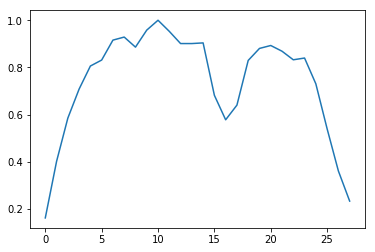

In [44]:
i = next(flow_hist_train_data)[0][0]
plt.plot(i[:28])
plt.show()


In [ ]:
show_imgs(train_data_flow_hist.next()[0][:45].reshape(45, 28,28))
show_imgs(test_data_flow.next()[0][:45].reshape(45, 28,28))

In [ ]:
d = train_data_flow.next()
np.savez('images_from_flow/autoscaled_augmented_train', targets=d[0].reshape(-1, ) 
print('done')

In [ ]:
show_imgs([random.choice(x_test).reshape(28,28) for i in range(45)])
show_imgs([random.choice(x_train).reshape(28,28) for i in range(45)])

In [ ]:
examples = [random.choice(x_train).reshape(28,28) for i in range(45)]
show_imgs(examples, title='No features')
show_imgs([feature_remove_dust(feature_smoothen(e)) for e in examples], title="'Dust' removal and smoothening")
show_imgs([feature_sobel(feature_remove_dust(feature_smoothen(e))) for e in examples], title="Sobelizing")

In [ ]:
for i in range(5):
    im = random.choice(x_train)
    im = feature_smoothen(im)
    im = feature_remove_dust(im)
    im = feature_autoscale(im)
    
    plt.subplot(311)
    plt.plot(feature_histogram_vert(im), label='Vertical histogram')
    plt.legend()
    
    plt.subplot(312)
    plt.plot(feature_histogram_horiz(im), label='Horizontal histogram')
    plt.legend()
    
    plt.subplot(313)
    plt.plot(feature_histogram_circ(im), label='I would call it a circular histogram')
    plt.legend()
    plt.show()

    plt.imshow(im)
    plt.show()


In [ ]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple = build_model(
    kl.InputLayer((28,28,1)),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.Dropout(0.2),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dropout(0.2),
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple = model_simple.fit(x_train_no_dust.reshape(INPUT_SHAPE), y_train,
                               validation_data=(x_valid_no_dust.reshape(INPUT_SHAPE), y_valid),
                               epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
print('Eval:', model_simple.evaluate(x_test_no_dust.reshape(INPUT_SHAPE), y_test, verbose=0))

plot_history(hist_simple, start_x_from=5)

In [ ]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple_autoscale = build_model(
    kl.InputLayer((28,28,1)),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.Dropout(0.2),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dropout(0.2),
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple_autoscale = model_simple_autoscale.fit(x_train_no_dust_autoscaled.reshape(INPUT_SHAPE), y_train,
                               validation_data=(x_test_no_dust_autoscaled.reshape(INPUT_SHAPE), y_test),
                               epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
print('Eval:', model_simple_autoscale.evaluate(x_test_no_dust_autoscaled.reshape(INPUT_SHAPE), y_test, verbose=0))

plot_history(hist_simple_autoscale, start_x_from=5)

In [ ]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple_sobel = build_model(
    kl.InputLayer((28,28,1)),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.Dropout(0.2),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dropout(0.2),
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple_sobel = model_simple_sobel.fit(x_train_no_dust_sobel.reshape(INPUT_SHAPE), y_train,
                               validation_data=(x_test_no_dust_sobel.reshape(INPUT_SHAPE), y_test),
                               epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
print('Eval:', model_simple_sobel.evaluate(x_test_no_dust_sobel.reshape(INPUT_SHAPE), y_test, verbose=0))

plot_history(hist_simple_sobel, start_x_from=5)

In [ ]:
model_lentil_reg = build_model(
    kl.InputLayer((28,28,1)),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Conv2D(filters=40, kernel_size=3, padding='same', activation='relu'),
    kl.Dropout(0.1),
    kl.MaxPool2D(pool_size=2, strides=2),


    kl.Conv2D(filters=50, kernel_size=5, padding='same', activation='relu'),
    kl.Dropout(0.1),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dropout(0.1),
    kl.Dense(units=200, activation='relu'),
    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lentil_reg = model_lentil_reg.fit_generator(generator=train_data_flow,
                                    validation_data=test_data_flow,
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=40, verbose=1)

In [ ]:
print('Eval:', model_lentil_reg.evaluate_generator(test_data_flow))

plot_history(hist_lentil_reg, start_x_from=5)

In [ ]:
model_just_dense = build_model(
    kl.InputLayer((168,)),
    
    kl.Dense(units=170, activation='elu'),
    kl.Dropout(0.2),
    kl.Dense(units=120, activation='elu'),
    kl.Dropout(0.1),
    kl.Dense(units=80, activation='elu'),
    kl.Dropout(0.1),
    kl.Dense(units=80, activation='elu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

#hist_just_dense = model_just_dense.fit(x_train_histograms, y_train,
#                                       validation_data=(x_test_histograms, y_test),
#                                       epochs=300, batch_size=2000, verbose=VERBOSE)

In [ ]:
hist_just_dense = model_just_dense.fit_generator(generator=train_data_flow_hist,
                                    validation_data=(x_test_histograms, y_test),
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=40, verbose=1)

print('Eval:', model_just_dense.evaluate(x_test_histograms, y_test))


plot_history(hist_just_dense, start_x_from=5)

In [ ]:
model_just_dense = build_model(
    kl.InputLayer((168,1)),
    kl.Flatten(),
    
    kl.Dense(units=168, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dropout(0.1),
    kl.Dense(units=168, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dense(units=100, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dropout(0.1),
    kl.Dense(units=60, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

In [ ]:
nexttrain_data_flow_hist)[0].shape

In [ ]:
hist_just_dense = model_just_dense.fit(x_train_histograms.reshape(-1, 168, 1), y_train,
                                       validation_data=(x_test_histograms.reshape(-1, 168, 1), y_test),
                                       epochs=500, batch_size=20000, verbose=VERBOSE)
print('Eval:', model_just_dense.evaluate(x_test_histograms.reshape(-1, 168, 1), y_test))


plot_history(hist_just_dense, start_x_from=0)